In [ ]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip.ref.extractall('./')

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

In [2]:
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [3]:
print(data.info())
print(f'\n\nCheck if any nulls \n{data.isnull().sum()}')
print(f'\n\nSummary data statistics \n{data.describe()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB
None


Check if any nulls 
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


Summary data statistics 
         InstanceID    patientID     cellType  isCancerous
count   9896.000000  9896.000000  9896.000000  9896.000000
mean   10193.880154    29.762025     1.501516     0.412187
std     6652.912660    17.486553     0.954867     0.492253
min        1.000000     1.000000     0.000000     0.000000
25%     4135.750000    14.000000    

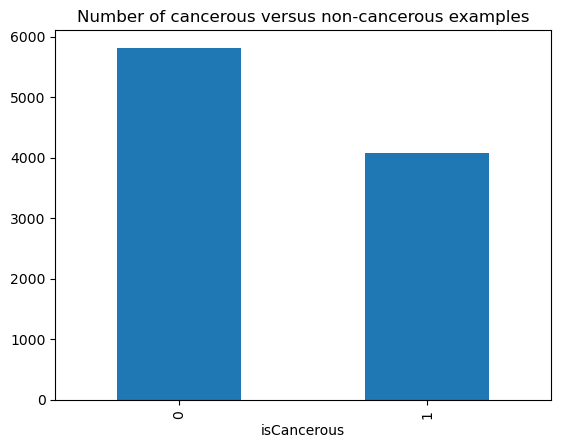

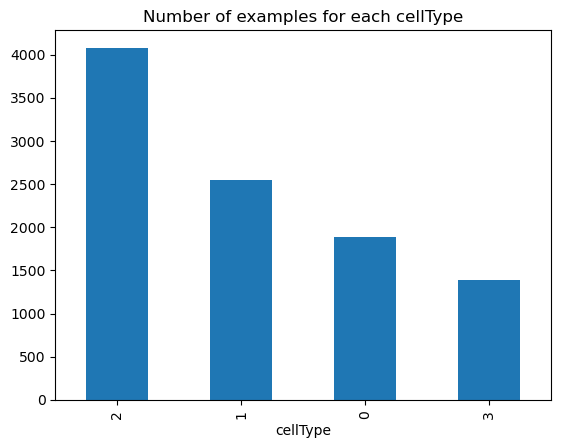

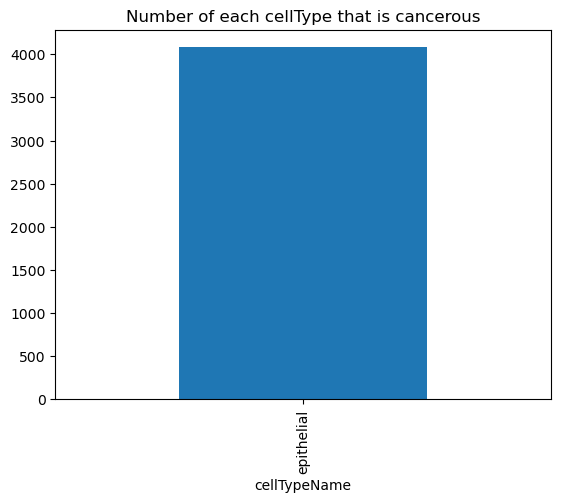

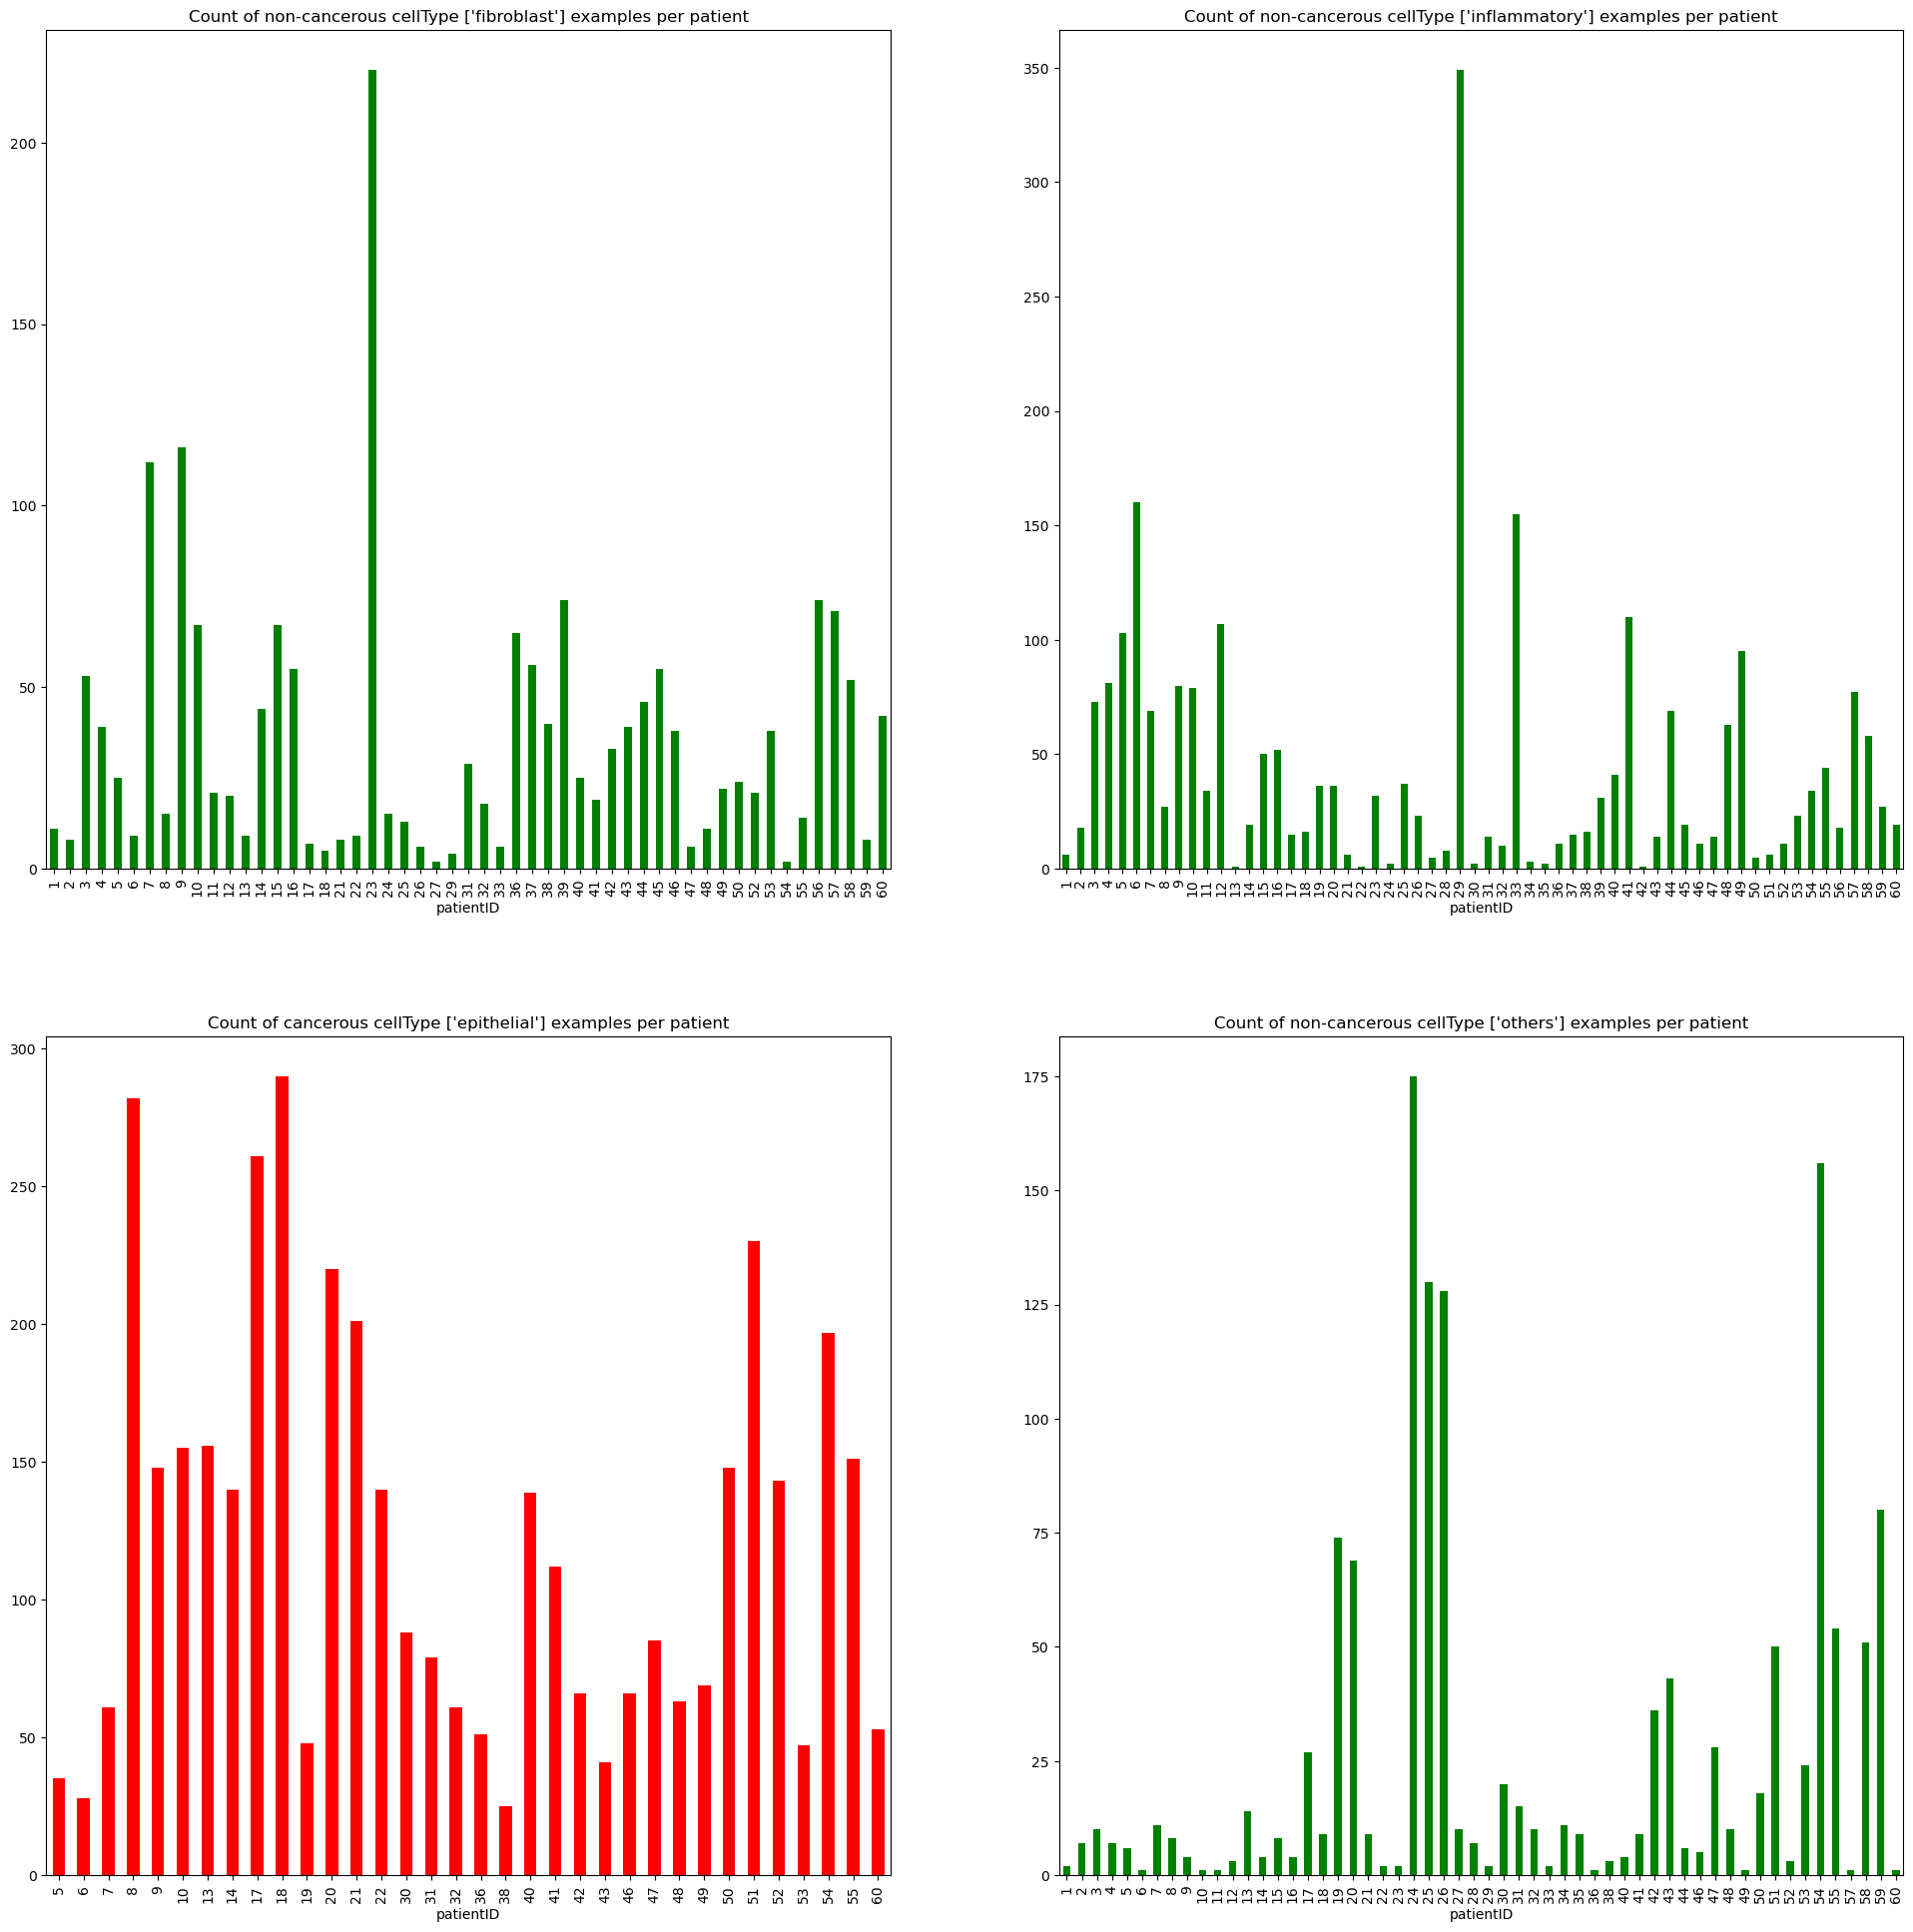

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import hog
# from skimage import data, exposure
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2gray


data['isCancerous'].value_counts().plot(kind='bar', title='Number of cancerous versus non-cancerous examples')
plt.show()
data['cellType'].value_counts().plot(kind='bar', title='Number of examples for each cellType')
plt.show()
data[data['isCancerous'] == 1]['cellTypeName'].value_counts().plot(kind='bar', title='Number of each cellType that is cancerous')
plt.show()



plt.figure(figsize=(24, 24))
for i in range(0, 4):
    plt.subplot(2, 2, i + 1)
    # Get rows where cellType = i and get value count of each patientID (how many patients have that cellType)
    byCellTypeCountCancerous = data[(data['cellType'] == i) & (data['isCancerous'] == 1)]['patientID'].value_counts().sort_index()
    byCellTypeCountNotCancerous = data[(data['cellType'] == i) & (data['isCancerous'] == 0)]['patientID'].value_counts().sort_index()
    if len(byCellTypeCountCancerous) > 0: 
        byCellTypeCountCancerous.plot(kind='bar', color='red', title=f'Count of cancerous cellType {data[data['cellType'] == i]['cellTypeName'].unique()} examples per patient')
    if len(byCellTypeCountNotCancerous) > 0:
        byCellTypeCountNotCancerous.plot(kind='bar', label='isCancerous = 0', color='green', title=f'Count of non-cancerous cellType {data[data['cellType'] == i]['cellTypeName'].unique()} examples per patient')
    
plt.show()

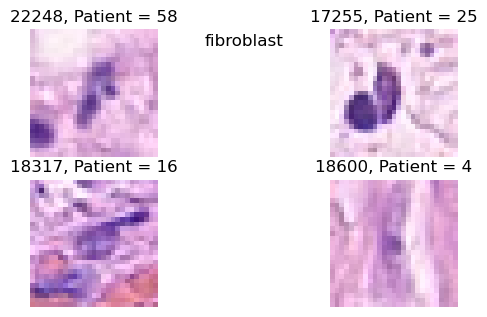

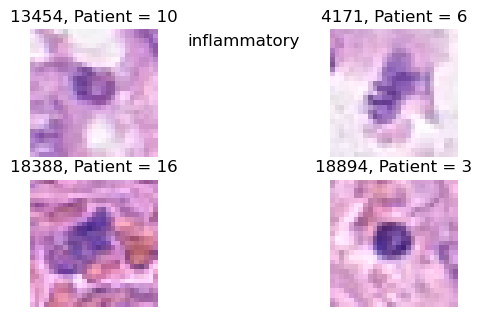

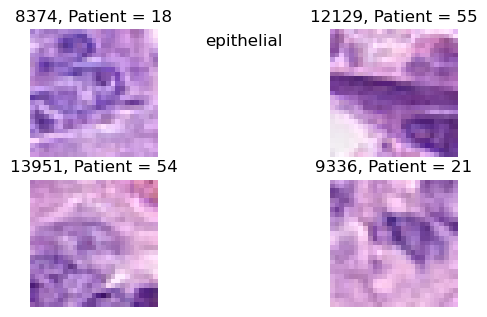

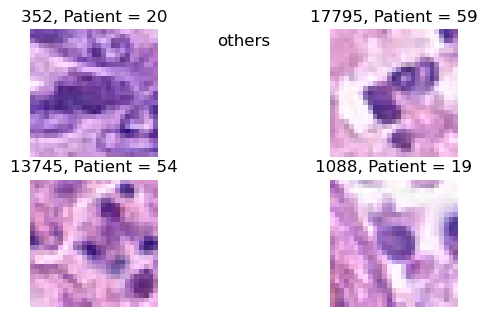

In [177]:
import math


celltype_dict = {}
for cell in data['cellType'].unique():
    celltype_dict[cell] = data[data['cellType'] == cell]


for i in range (len(celltype_dict)):
    celltype = celltype_dict[i]
    num = 8
    col = 2
    row = math.ceil(num/col)
    plt.figure(figsize=(col * 3, row * 3))
    sample = celltype.sample(n=4)
    for j in range(len(sample)):
        image_path = sample.iloc[j]['ImageName']
        im = imread(f'./Image_classification_data/patch_images/{image_path}', as_gray=False, plugin=None)
        plt.subplot(num, col, j + 1)
        plt.title(f'{sample.iloc[j]['InstanceID']}, Patient = {sample.iloc[j]['patientID']}')
        plt.imshow(im, cmap=plt.cm.gray)
        plt.axis('off')
    plt.tight_layout(pad=0.0, h_pad=0.2, w_pad=0.0)
    plt.suptitle(sample.iloc[1]['cellTypeName'])
    plt.show()
        

In [ ]:
# F1 Score



In [2]:
# Data splitting

patient_dict = {}
for id  in data['patientID'].unique():
    patient_dict[id] = data[data['patientID'] == id]

patients_groupByCancerous = {}
patients_groupByNonCancerous = {}
for id, value in patient_dict.items():
    if patient_dict[id]['isCancerous'].eq(1).any():
        patients_groupByCancerous[id] = value
    else:
        patients_groupByNonCancerous[id] = value

print(f'Total number of patients is: {len(patients_groupByCancerous) + len(patients_groupByNonCancerous)}')
print(f'With {len(patients_groupByCancerous)} patients with a cancerous cell versus {len(patients_groupByNonCancerous)} patients with no cancerous cells')

# cancerousExamples = data[data['isCancerous'] == 1]
# nonCancerousExamples = data[data['isCancerous'] == 0]

# cancerousExamples_groupbypatient = {}
# for id in cancerousExamples['patientID'].unique():
#     cancerousExamples_groupbypatient[id] = cancerousExamples[cancerousExamples['patientID'] == id]

# nonCancerousExamples_groupbypatient = {}
# for id in nonCancerousExamples['patientID'].unique():
#     nonCancerousExamples_groupbypatient[id] = nonCancerousExamples[nonCancerousExamples['patientID'] == id]

TRAIN_SPLIT_PERCENT = 0.80
VALID_SPLIT_PERCENT = 0.20
TEST_SPLIT_PERCENT = 0.80
TOTAL_IMAGES = len(data)
RATIO = len(data[data['isCancerous'] == 1]) / TOTAL_IMAGES

train = pd.DataFrame(columns=data.columns)
test = pd.DataFrame(columns=data.columns)
val = pd.DataFrame(columns=data.columns)

# Pick random patients from canerous and non cancerous group 
train_split_Cancerous_keys = pd.DataFrame(list(patients_groupByCancerous.keys()), columns=['patientID']).sample(frac=TRAIN_SPLIT_PERCENT, random_state=10).reset_index(drop=True)
train_split_nonCancerous_keys = pd.DataFrame(list(patients_groupByNonCancerous.keys()), columns=['patientID']).sample(frac=TRAIN_SPLIT_PERCENT, random_state=10).reset_index(drop=True)

# From the train set pick random patients for val set
val_split_Cancerous_keys = train_split_Cancerous_keys.sample(frac=VALID_SPLIT_PERCENT, random_state=10).reset_index(drop=True)
val_split_nonCancerous_keys = train_split_nonCancerous_keys.sample(frac=VALID_SPLIT_PERCENT, random_state=10).reset_index(drop=True)


print(f'- For train set, picked {len(train_split_Cancerous_keys)} patients out of {len(patients_groupByCancerous)} patients with cancerous cells')
# print(f'They are \n {train_split_Cancerous_keys}')
print(f'- For train set, picked {len(train_split_nonCancerous_keys)} patients out of {len(patients_groupByNonCancerous)} patients with non cancerous cells')
print(f'- Therefore, there is a ratio of cancerous to total patients in train set of {len(train_split_Cancerous_keys)/(len(train_split_nonCancerous_keys) + len(train_split_Cancerous_keys))} ')
print(f'- Therefore, there is a ratio of cancerous to total patients in test set of {(len(train_split_Cancerous_keys ) - len(patients_groupByCancerous)) /(len(train_split_nonCancerous_keys) + len(train_split_Cancerous_keys) - (len(patients_groupByNonCancerous) + len(patients_groupByCancerous)))} ')

print(f'- For val set, picked {len(val_split_Cancerous_keys)} patients out of {len(train_split_Cancerous_keys)} train set patients with cancerous cells')
print(f'- For val set, picked {len(val_split_nonCancerous_keys)} patients out of {len(train_split_nonCancerous_keys)} train set patients with non cancerous cells')
print(f'- Therefore, there is a ratio of cancerous to total patient in val set of {len(val_split_Cancerous_keys)/(len(val_split_Cancerous_keys) + len(val_split_nonCancerous_keys))}')

# Now based on picks for train set place the patients in the train set otherwise in the test set.
for id, key in patients_groupByCancerous.items():
    # If key of patient is selected for train then place it in the train set else in the test set
    if train_split_Cancerous_keys['patientID'].eq(id).any():
        if val_split_Cancerous_keys['patientID'].eq(id).any():
            val = pd.concat([val, patients_groupByCancerous[id]], ignore_index=True)
        else:
            train = pd.concat([train, patients_groupByCancerous[id]], ignore_index=True)
    else:
        test = pd.concat([test, patients_groupByCancerous[id]], ignore_index=True)

for id, key in patients_groupByNonCancerous.items():
    # If key of patient is selected for train then place it in the train set else in the test set
    if train_split_nonCancerous_keys['patientID'].eq(id).any():
        if val_split_nonCancerous_keys['patientID'].eq(id).any():
            val = pd.concat([val, patients_groupByNonCancerous[id]], ignore_index=True)
        else:
            train = pd.concat([train, patients_groupByNonCancerous[id]], ignore_index=True)
    else:
        test = pd.concat([test, patients_groupByNonCancerous[id]], ignore_index=True)

print(f'- There is {len(train['patientID'].unique())} patients in the train set. The count for each cell type is:\n{train['cellType'].value_counts()}')
print(f'- There is {len(val['patientID'].unique())} patients in the val set. The count for each cell type is:\n{val['cellType'].value_counts()}')
print(f'- There is {len(test['patientID'].unique())} patients in the test set. The count for each cell type is:\n{test['cellType'].value_counts()}')
print(f'- Therefore, ratio of train to total is: {len(train)/ len(data)} versus the ratio of test to total: {len(test)/len(data)}')
print(f'- Therefore, ratio of val to train is: {len(val)/len(train)}, and the ratio of val to total is: {len(val)/len(data)}') 

print(f'- The value counts for isCancerous for train set is:\n{train['isCancerous'].value_counts()}')
print(f'- The value counts for isCancerous for val set is:\n{val['isCancerous'].value_counts()}')
print(f'- The value counts for isCancerous for test set is:\n{test['isCancerous'].value_counts()}')
print(f'- The value counts for isCancerous for whole data set is:\n{data['isCancerous'].value_counts()}')


# I could make the splitter above modular but cannot be bothered for

Total number of patients is: 60
With 34 patients with a cancerous cell versus 26 patients with no cancerous cells
- For train set, picked 27 patients out of 34 patients with cancerous cells
- For train set, picked 21 patients out of 26 patients with non cancerous cells
- Therefore, there is a ratio of cancerous to total patients in train set of 0.5625 
- Therefore, there is a ratio of cancerous to total patients in test set of 0.5833333333333334 
- For val set, picked 5 patients out of 27 train set patients with cancerous cells
- For val set, picked 4 patients out of 21 train set patients with non cancerous cells
- Therefore, there is a ratio of cancerous to total patient in val set of 0.5555555555555556
- There is 39 patients in the train set. The count for each cell type is:
cellType
2    2630
0    1454
1    1447
3     930
Name: count, dtype: int64
- There is 9 patients in the val set. The count for each cell type is:
cellType
1    679
2    553
0    222
3    158
Name: count, dtype: i

In [74]:
# Data generator + Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

OUTPUT_CLASSES_CELLTYPE = 4

# For some reason ImageDataGenerator needs classes to be strings
train['cellType'] = train['cellType'].astype(str)
val['cellType'] = val['cellType'].astype(str)


# Lets do bit of normalisation with pixel values -> faster training
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# A hyperparameter?
batch_size = 27

# For cellType classification
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train,
    directory = './Image_classification_data/patch_images/',
    x_col = 'ImageName',
    y_col = 'cellType',
    target_size=(27, 27),
    batch_size = batch_size,
    class_mode = 'categorical' # Creates onehot encoded labels
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = val,
    directory = './Image_classification_data/patch_images/',
    x_col = 'ImageName',
    y_col = 'cellType',
    target_size=(27, 27),
    batch_size = batch_size,
    class_mode = 'categorical'
)

# For cancerous classification


train['isCancerous'] = train['isCancerous'].astype(str)
val['isCancerous'] = val['isCancerous'].astype(str)

OUTPUT_CLASSES_ISCANCEROUS = 2

train_generator_cancerous = train_datagen.flow_from_dataframe(
    dataframe = train,
    directory = './Image_classification_data/patch_images/',
    x_col = 'ImageName',
    y_col = 'isCancerous',
    target_size=(27, 27),
    batch_size = batch_size,
    class_mode = 'categorical' # Creates onehot encoded labels
)

validation_generator_cancerous = val_datagen.flow_from_dataframe(
    dataframe = val,
    directory = './Image_classification_data/patch_images/',
    x_col = 'ImageName',
    y_col = 'isCancerous',
    target_size=(27, 27),
    batch_size = batch_size,
    class_mode = 'categorical' # Creates onehot encoded labels
)

Found 6461 validated image filenames belonging to 4 classes.
Found 1612 validated image filenames belonging to 4 classes.
Found 6461 validated image filenames belonging to 2 classes.
Found 1612 validated image filenames belonging to 2 classes.


In [82]:
# Model Development

import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name, suptitle):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.suptitle(f'{suptitle}')
    plt.show()

In [75]:
import tensorflow as tf


model_VGG_1 = tf.keras.Sequential([
    # First feature extraction
    #VGG block 1
    # 32 (3x3, 3 Channels) Kernels. output => 27x27, 32 Feature Maps)
    # padding = 'same': output size = input size (see ref [1])  stride = 1 (the skip between middle of kernel) 
    # padding is adjusted to ensure same size output as input  
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Down sampling using max pooling. Reduces size by 2.
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    # More filters to learn more complex patterns
    # Learns patterns of the patterns in features maps of above block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(127, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Then decision maker
    # convert the ?D output tensor into a 1D Vector. if second last layer is 4x4 then (4 * 4 * 128)
    # Allows dense (fully connected) layer to make connections between activations in across many feature maps to classes?  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_CELLTYPE),
])


model_VGG_2 = tf.keras.Sequential([
    # First feature extraction
    #VGG block 1
    # 32 (3x3, 3 Channels) Kernels. output => 27x27, 32 Feature Maps)
    # padding = 'same': output size = input size (see ref [1])  stride = 1 (the skip between middle of kernel) 
    # padding is adjusted to ensure same size output as input  
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Down sampling using max pooling. Reduces size by 2.
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    # More filters to learn more complex patterns
    # Learns patterns of the patterns in features maps of above block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(127, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Then decision maker
    # convert the ?D output tensor into a 1D Vector. if second last layer is 4x4 then (4 * 4 * 128)
    # Allows dense (fully connected) layer to make connections between activations in across many feature maps to classes?  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_ISCANCEROUS),
])

/home/voyage/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
from tensorflow.keras.metrics import Precision, Recall
# Optimizer = how to update weight
# 'adam' = (Adaptive Moment Estimation) https://www.geeksforgeeks.org/adam-optimizer/
model_VGG_1.compile(optimizer='adam',
            # IDK IF below are true for sure
            # SparseCategoricalCrossentropy expects a column with labels: 0, 1, 2, 3... then turns them into one-hot representation
            # CategoricalCrossentropy expects one-hot encoded labels: [0, 1, 0, 0]
            # from_logits means final layer doesn't have softmax activation. raw outputs. therefore keras will apply softmax inside loss func.
            # https://stackabuse.com/what-is-fromlogitstrue-in-keras-tensorflow-loss-functions/
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy', 'precision', 'recall']
              )


model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['precision', 'recall']
              )

In [ ]:
# cellType
history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=1)

In [79]:
# isCancerous
history_VGG_2 = model_VGG_2.fit(train_generator_cancerous, validation_data= validation_generator_cancerous, epochs=15, verbose=1)

Epoch 1/15


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.6670 - precision: 0.7403 - recall: 0.0412

/home/voyage/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - loss: 0.6669 - precision: 0.7408 - recall: 0.0414 - val_loss: 0.3959 - val_precision: 0.9055 - val_recall: 0.5409
Epoch 2/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - loss: 0.4105 - precision: 0.8914 - recall: 0.5673 - val_loss: 0.3867 - val_precision: 0.8429 - val_recall: 0.6458
Epoch 3/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - loss: 0.3544 - precision: 0.9009 - recall: 0.7006 - val_loss: 0.2908 - val_precision: 0.9044 - val_recall: 0.7395
Epoch 4/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - loss: 0.3040 - precision: 0.9205 - recall: 0.7661 - val_loss: 0.2704 - val_precision: 0.9463 - val_recall: 0.6892
Epoch 5/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 0.3035 - precision: 0.9322 - recall: 0.7289 - val_loss: 0.3915 - val_precision: 0.8509 - val_recall: 0.6551
Epoch 6/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.2635 - precision: 0.9347 - recall: 0.7962 - val_loss: 0.3588 - val_precision: 0.8833 - val_recall

In [63]:
def f1_score(precision, recall):
    f1 = []
    for i in range(len(precision)):
        if precision[i] + recall[i] == 0:
            f1.append(0.0)
        else:
            f1.append(precision[i] * recall[i])
            f1[i] = f1[i] / (precision[i] + recall[i])
            f1[i] = 2 * f1[i]
            
    return f1
    

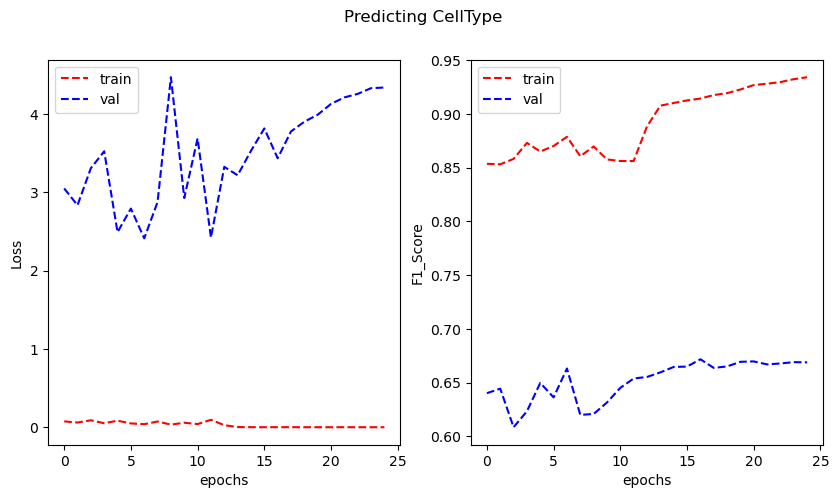

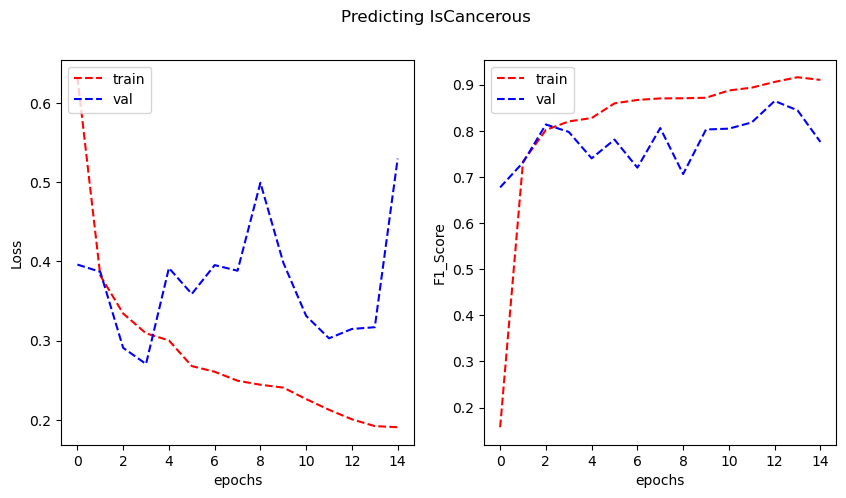

In [83]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    f1_score(history_VGG_1.history['precision'], history_VGG_1.history['recall']), f1_score(history_VGG_1.history['val_precision'], history_VGG_1.history['val_recall']), 
                    metric_name='F1_Score', suptitle="Predicting CellType")

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    f1_score(history_VGG_2.history['precision'], history_VGG_2.history['recall']), f1_score(history_VGG_2.history['val_precision'], history_VGG_2.history['val_recall']), 
                    metric_name='F1_Score', suptitle="Predicting IsCancerous")

In [ ]:
# Appendix



# Plot of images related to each patient

# for i in range(0, 3):
#     patient = patient_dict[i]
#     num = len(patient)
#     col = 5
#     row = math.ceil(num/col)
#     plt.figure(figsize=(col * 4, row * 4))
#     for j in range(0, len(patient)):
#         # print(j)
#         image_path = patient.iloc[j]['ImageName']
#         # print(image_path)
#         im = imread(f'./Image_classification_data/patch_images/{image_path}', as_gray=True, plugin=None)
#         # print('yes')
#         plt.subplot(num, col, j + 1)
#         plt.title(f'{patient.iloc[j]['InstanceID']}, Cell = {patient.iloc[j]['cellTypeName']}')
#         plt.imshow(im, cmap=plt.cm.gray)
#         plt.axis('off')
#     plt.tight_layout(pad=0.5, h_pad=0.2, w_pad=0.2)
#     plt.show()

   